In [4]:
import pandas as pd
task_list = ["cardiac", "prostate_mri", "fundus_dofe","spinal"]
task_paths = [f"/media/morikawa/DataHDD/home/data/segmentation/{task}/semi/domain_generalization/experiment_client_" for task 
              in task_list]
tasks = {"cardiac":task_paths[0],
         "prostate_mri":task_paths[1],
         "fundus_dofe":task_paths[2],
         "spinal":task_paths[3]}


In [1]:
import os
from pathlib import Path
import pandas as pd
labelpaths = [f"/media/morikawa/DataHDD/home/data/segmentation/spinal/semi/client_{i}/labeled_data.csv" for i in range(1,5)]
unlabelpaths = [f"/media/morikawa/DataHDD/home/data/segmentation/spinal/semi/client_{i}/unlabeled_data.csv" for i in range(1,5)]
print("Spine")
for i in range(len(labelpaths)):
    label = Path(labelpaths[i])
    unlabel = Path(unlabelpaths[i])
    l_d = pd.read_csv(label)
    ul_d = pd.read_csv(unlabel)
    length = len(l_d) + len(ul_d)
    print(f'site{i+1} : total {length}, label {len(l_d)}, unlabel {len(ul_d)}')

Spine
site1 : total 60, label 30, unlabel 30
site2 : total 216, label 113, unlabel 103
site3 : total 370, label 170, unlabel 200
site4 : total 266, label 134, unlabel 132


In [5]:

import os

loop = [4]
loop_task = { "spinal":4}
j = 0
last_path = None
for task in ["spinal"]:
    task_path = tasks[task]
    for i in range(1, loop_task[task]+1):
        cl_path = task_path + str(i)
        test_path = os.path.join(cl_path, "test.csv")
        train_path = os.path.join(cl_path, "train.csv")
        label_path = os.path.join(cl_path,'labeled.csv')
        unlabel_path = os.path.join(cl_path, "unlabeled.csv")
        test = pd.read_csv(test_path)
        train = pd.read_csv(train_path)
        label = pd.read_csv(label_path)
        unlabel = pd.read_csv(unlabel_path)
        
        last_path = train
        print(f'client_{i}',"data size: ",len(test), "  label data size : ", len(label), " unlabel data size : ", len(unlabel))
        print(len(train))
    j = j+1

client_1 data size:  30   label data size :  90  unlabel data size :  762
417
client_2 data size:  113   label data size :  90  unlabel data size :  606
334
client_3 data size:  170   label data size :  90  unlabel data size :  452
277
client_4 data size:  134   label data size :  90  unlabel data size :  556
313


In [6]:
import numpy as np
from PIL import Image
index = 10
data = last_path.iloc[index]

image_path = data['image_vis_path']
train_np_path = data['image_train_path']
mask_path = data['segmentation_mask_path']

image = np.load(train_np_path)
mask = np.array(Image.open(mask_path))
grey_mask = (mask >= 1).astype(float)
print(grey_mask)
print(f'image.shape : {image.shape}, image: {len(np.unique(image))}')
print(f'mask.shape : {mask.shape},  mask : {np.unique(mask)}')
unique_elements, counts = np.unique(grey_mask[grey_mask == 1], return_counts=True)
print("ユニークな要素:", unique_elements)
print("各要素の出現回数:", counts)
print(image_path)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
image.shape : (256, 256), image: 65420
mask.shape : (256, 256),  mask : [0 1 2]
ユニークな要素: [1.]
各要素の出現回数: [2353]
/media/morikawa/DataHDD/home/data/segmentation/spinal/semi/client_3/data/sc03/img_vis/sc03_6.png


In [7]:
import os
import sys
import pandas as pd
import random
import numpy as np
from glob import glob
import nibabel as nib

import yaml
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

current_dir = Path().parent
parent_dir = current_dir.parent
sys.path.append(str(parent_dir))

filepath =Path("/media/morikawa/DataHDD/home/centralized/configs/spinal/scripts_conf.yaml")
config = yaml.safe_load(open(filepath, 'r'))
target_folder = config.get("target_folder", "~/spinal/semi")
raw_data_folder = config.get("raw_data_folder","~/spinal/spinal_data")
random.seed(config.get("seed",0))
resize = (config.get("resize")['width'], config.get("resize")['height'])
training_folder = raw_data_folder
test_folder = os.path.join(raw_data_folder, "test-data")
image_paths = [os.path.join(training_folder,f"site3-sc0{i}-image.nii.gz") for i in range(3,8) ]
mask_paths = [os.path.join(training_folder,f"site3-sc09-mask-r{i}.nii.gz") for i in range(1,5)]
#image_path = "/media/morikawa/DataHDD/home/data/segmentation/cardiac/OpenDataset/Training/Labeled/A0S9V9/A0S9V9_sa.nii.gz"
#mask_path = "/media/morikawa/DataHDD/home/data/segmentation/prostate_mri/data/HK/Case38_segmentation.nii.gz"


In [15]:
from scipy.stats import mode

def load_and_vote_masks(mask_files):

    mask_list = []
    for mask_file in mask_files:
        current_mask = nib.load(mask_file).get_fdata().astype(int)
        mask_list.append(current_mask)
    
    # マスクをスタック（形状: X, Y, Z, N）
    mask_stack = np.stack(mask_list, axis=-1)
    final_mask, _ = mode(mask_stack, axis=-1)
    final_mask = final_mask.astype(np.int32)
    
    return final_mask

f_mask = load_and_vote_masks(mask_paths)
print(np.unique(f_mask))

KeyboardInterrupt: 

28


<Figure size 640x480 with 0 Axes>

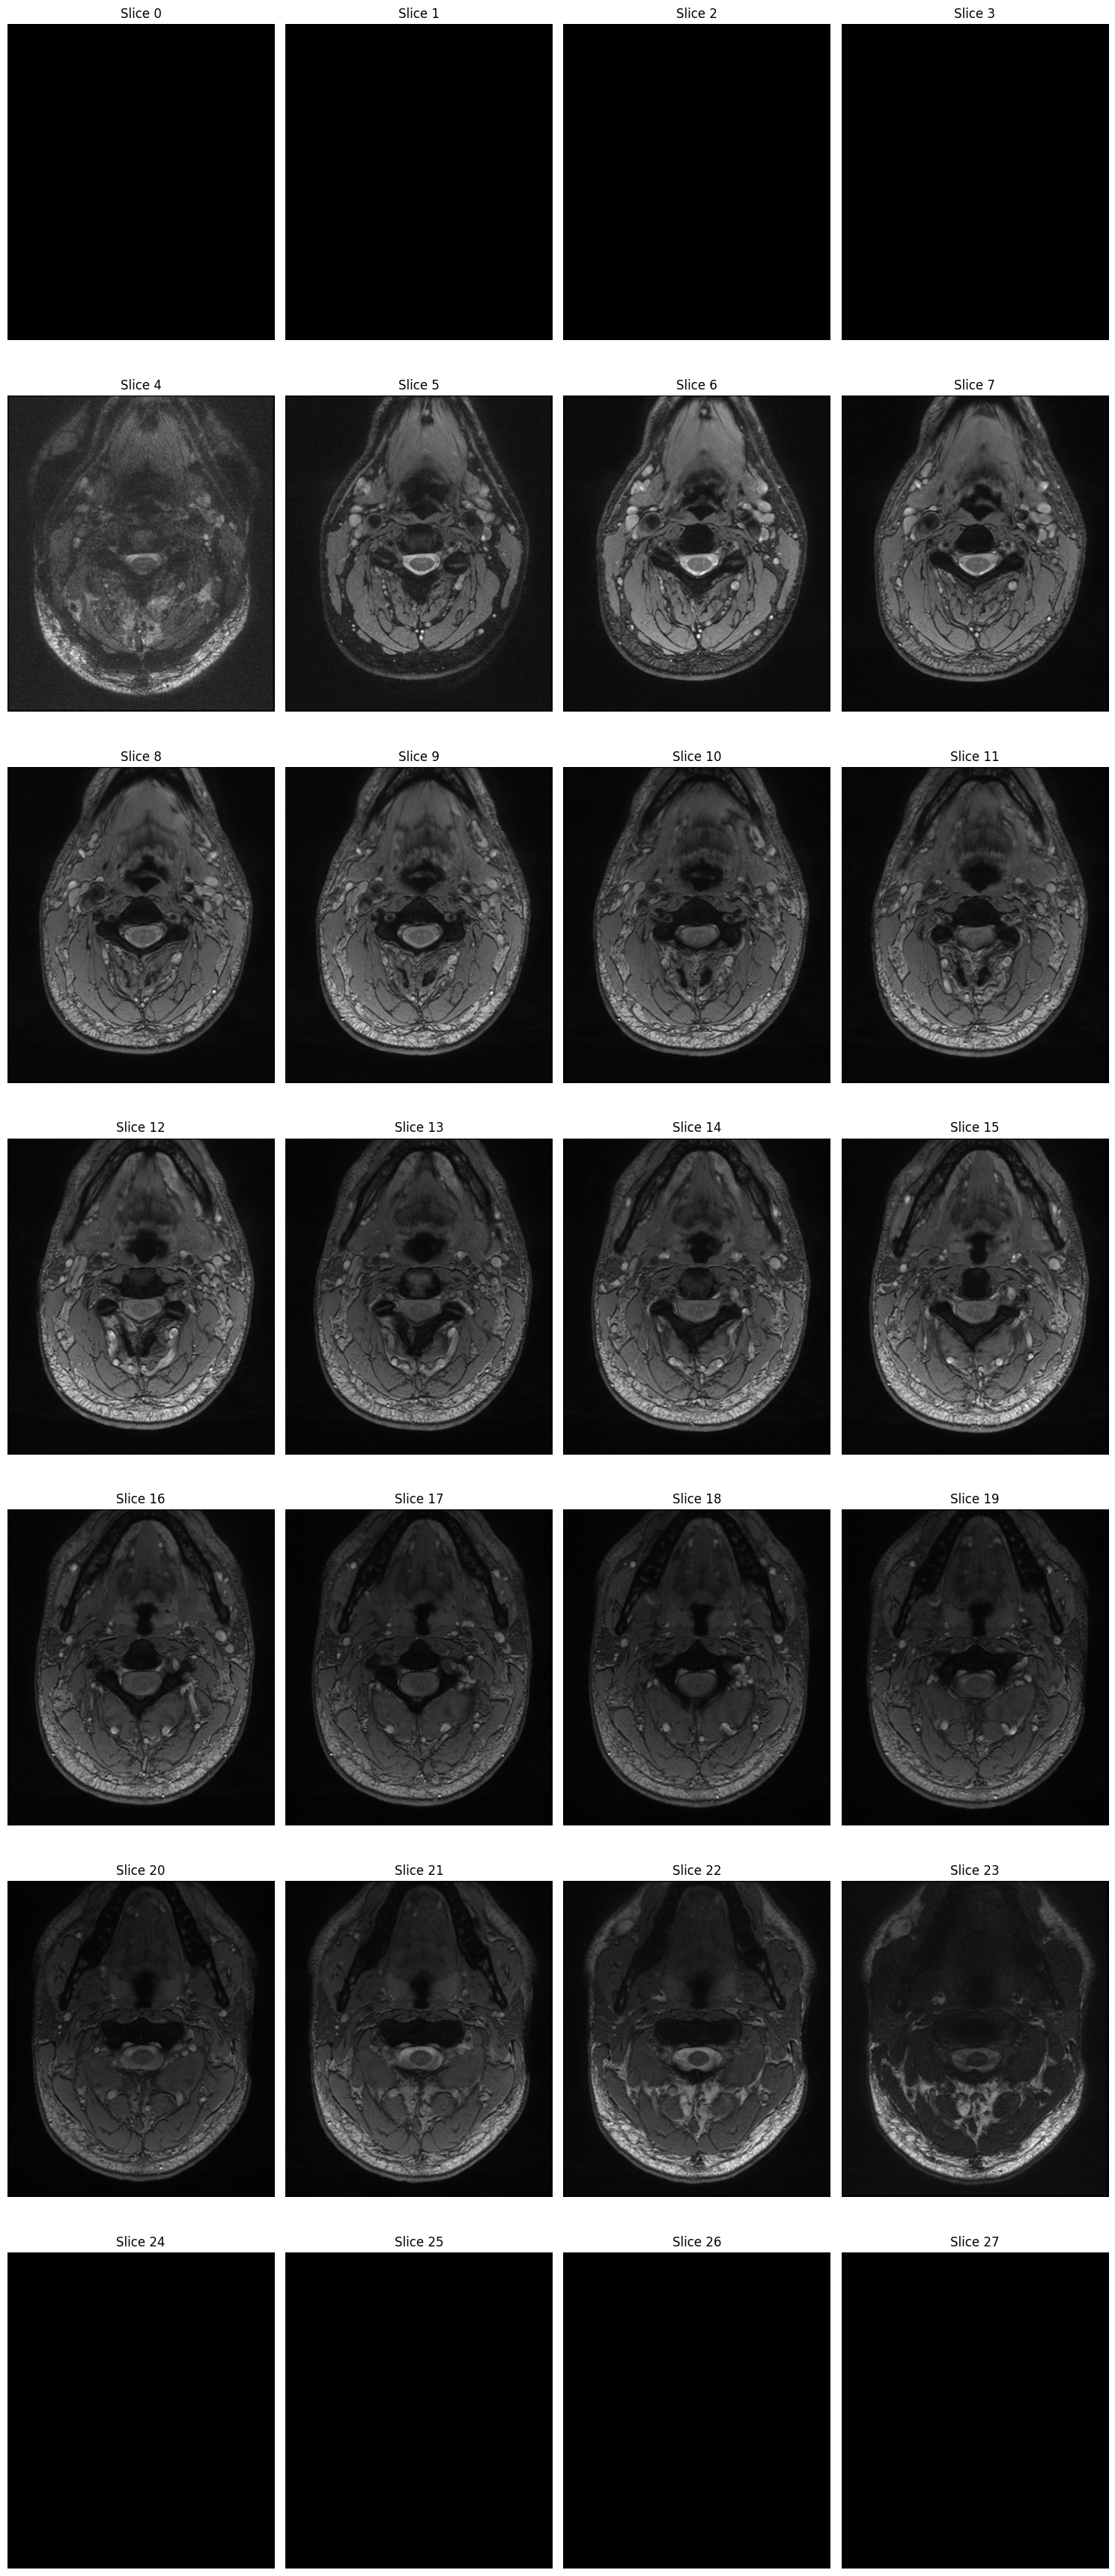

In [8]:
import math
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from PIL import Image
plt.clf()
image_paths = [os.path.join("/media/morikawa/DataHDD/home/data/segmentation/spinal/spinal_data/test-data",f"site3-sc1{i}-image.nii.gz") for i in range(3,9) ]

site1_path = image_paths[-1]
img1_nib = nib.load(site1_path)
img1 = img1_nib.get_fdata()

num_slices = img1.shape[2]
num_cols = 4
num_rows = math.ceil(num_slices / num_cols)

# フィギュアサイズを行数に応じて調整
fig_height = 5 * num_rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, fig_height))

print(num_slices)

# axesを2次元配列から1次元にフラット化
axes = axes.flatten()

for slice_idx in range(num_slices):
    img_slice = img1[:, :, slice_idx]

    axes[slice_idx].imshow(img_slice.T, cmap='gray', origin='lower')
    axes[slice_idx].set_title(f'Slice {slice_idx}')
    axes[slice_idx].axis('off')  # 軸を非表示

# 余分なサブプロットを非表示にする
for ax in axes[num_slices:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

site 1 (100, 100, 3)
site 2 (320, 320, 12)
site 3 (655, 774, 28)
site 4 (560, 560, 14)


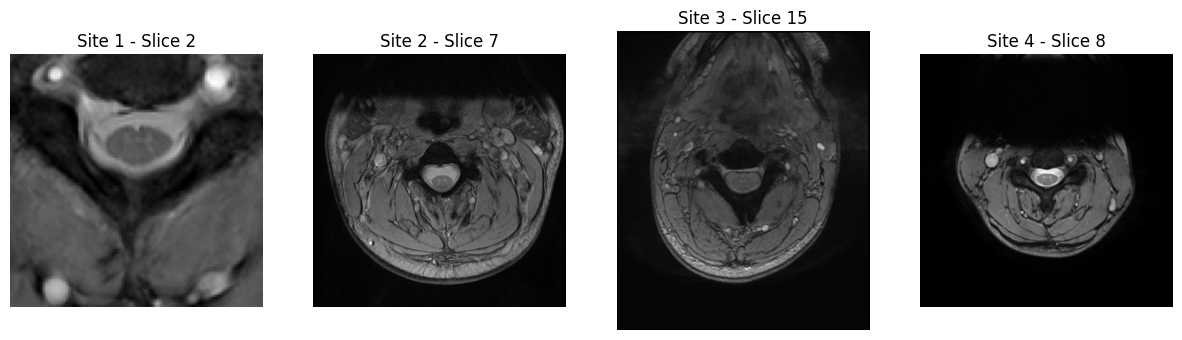

In [10]:

num_imgs = len(image_paths)
fig, axes = plt.subplots(1, num_imgs, figsize=(15, 5))

for i, img_file in enumerate(image_paths):
    img = nib.load(img_file).get_fdata()
    print(f"site {i+1}",img.shape)

    slice_idx = img.shape[-1] // 2+1
    img_slice = img[:, :, slice_idx]
    
    # スライスをサブプロットに表示
    axes[i].imshow(img_slice.T, cmap='gray', origin='lower')
    axes[i].set_title(f'Site {i+1} - Slice {slice_idx}')
    axes[i].axis('off')  # 軸を非表示

FileNotFoundError: No such file or no access: '/media/morikawa/DataHDD/home/data/segmentation/spinal/spinal_data/site3-sc09-mask-r1.nii.gz'

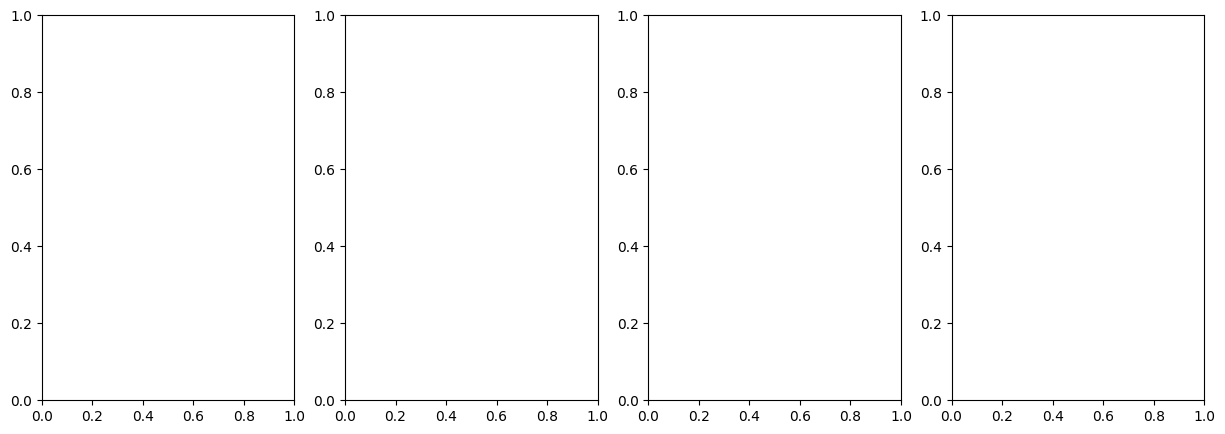

In [9]:
num_masks = len(mask_paths)
fig, axes = plt.subplots(1, num_masks, figsize=(15, 5))

# 各マスクファイルの最初のスライスをサブプロットに表示
for i, mask_file in enumerate(mask_paths):
    mask = nib.load(mask_file).get_fdata()
    print(mask.shape)
    # 最初のスライスを取得
    slice_idx = 0
    mask_slice = mask[:, :, slice_idx]
    
    # スライスをサブプロットに表示
    axes[i].imshow(mask_slice.T, cmap='gray', origin='lower')
    axes[i].set_title(f'Mask {i+1} - Slice {slice_idx}')
    axes[i].axis('off')  # 軸を非表示


# サブプロットの間のレイアウトを調整
plt.tight_layout()
plt.show()

In [10]:
from scipy.stats import mode

def load_and_vote_masks(mask_files):

    mask_list = []
    for mask_file in mask_files:
        current_mask = nib.load(mask_file).get_fdata().astype(int)
        mask_list.append(current_mask)
    
    # マスクをスタック（形状: X, Y, Z, N）
    mask_stack = np.stack(mask_list, axis=-1)
    final_mask, _ = mode(mask_stack, axis=-1)
    final_mask = final_mask.astype(np.int32)
    
        
    return final_mask

f_mask = load_and_vote_masks(mask_paths)
print(f_mask.shape)
slice_idx = 0
plt.imshow(f_mask[:,:,slice_idx].T, cmap='gray', origin='lower')
plt.title(f'Slice {slice_idx}')
plt.axis('off')  
plt.show()

FileNotFoundError: No such file or no access: '/media/morikawa/DataHDD/home/data/segmentation/spinal/spinal_data/site3-sc09-mask-r1.nii.gz'

In [ ]:
import numpy as np
import nibabel as nib
import SimpleITK as sitk

def resample_image(img, target_voxel_size=(0.25, 0.25)):
    try:
        original_affine = img.affine
        img_data = img.get_fdata()

        # デバッグ情報の表示
        print("Original image shape:", img_data.shape)

        # NumPy配列を転置して軸の順序を(X, Y, Z)に変更
        img_data = np.transpose(img_data, (2, 1, 0))
        print("Transposed image shape:", img_data.shape)

        # アフィン行列からスペーシング、原点、方向を取得
        def affine_to_components(affine):
            spacing = np.sqrt(np.sum(affine[:3, :3] ** 2, axis=0))
            direction = (affine[:3, :3] / spacing).flatten()
            origin = affine[:3, 3]
            return spacing, origin, direction

        original_spacing, origin, direction = affine_to_components(original_affine)
        print("Original spacing:", original_spacing)
        print("Origin:", origin)
        print("Direction:", direction)

        # 入力画像をSimpleITK形式に変換し、スペーシング、原点、方向を設定
        sitk_image = sitk.GetImageFromArray(img_data)
        sitk_image.SetSpacing(original_spacing)
        sitk_image.SetOrigin(origin)
        sitk_image.SetDirection(direction)

        # 出力スペーシングを設定（z軸は元のスペーシングを維持）
        output_spacing = [target_voxel_size[0], target_voxel_size[1], original_spacing[2]]
        print("Output spacing:", output_spacing)

        # 出力サイズを計算
        input_size = sitk_image.GetSize()
        output_size = [
            int(np.round(input_size[0] * (original_spacing[0] / output_spacing[0]))),  # x軸
            int(np.round(input_size[1] * (original_spacing[1] / output_spacing[1]))),  # y軸
            input_size[2]  # z軸はリサンプリングしない
        ]
        print("Input size:", input_size)
        print("Output size:", output_size)

        # リサンプリングフィルタの設定
        resampler = sitk.ResampleImageFilter()
        resampler.SetInterpolator(sitk.sitkBSpline)  # 高次のBスプライン補間
        resampler.SetOutputSpacing(output_spacing)
        resampler.SetSize(output_size)
        resampler.SetOutputOrigin(origin)
        resampler.SetOutputDirection(direction)

        # リサンプリングの実行
        resampled_sitk_image = resampler.Execute(sitk_image)

        # NumPy配列に変換し、軸を元に戻す
        resampled_data = sitk.GetArrayFromImage(resampled_sitk_image)
        resampled_data = np.transpose(resampled_data, (2, 1, 0))
        print("Resampled data shape:", resampled_data.shape)

        # 新しいアフィン行列を作成
        new_affine = np.eye(4)
        new_affine[:3, :3] = np.array(direction).reshape(3, 3) * output_spacing
        new_affine[:3, 3] = origin

        return resampled_data, new_affine

    except Exception as e:
        print("An error occurred in resample_image function:", str(e))
        return None, None

# 画像の読み込み
img = nib.load(image_path)

# 画像のリサンプリング
resampled_data, new_affine = resample_image(img, target_voxel_size=(0.25, 0.25))
if resampled_data is None:
    print("Failed to resample the image.")
else:
    print("画像のリサンプリングを完了しました。")
    print(resampled_data.shape)

# マスクのリサンプリング
mask_nifti = nib.Nifti1Image(f_mask, affine=img.affine)
resampled_mask_data, _ = resample_image(mask_nifti, target_voxel_size=(0.25, 0.25))
if resampled_mask_data is None:
    print("Failed to resample the mask.")
else:
    print("マスクのリサンプリングを完了しました。")
    print(resampled_mask_data.shape)


Original image shape: (100, 100, 3)
Transposed image shape: (3, 100, 100)
Original spacing: [0.5        0.5        4.99999905]
Origin: [ 24.75       -24.75        -4.99999905]
Direction: [-1.  0.  0.  0.  1.  0.  0.  0.  1.]
Output spacing: [0.25, 0.25, 4.999999046325684]
Input size: (100, 100, 3)
Output size: [200, 200, 3]
Resampled data shape: (200, 200, 3)
画像のリサンプリングを完了しました。
(200, 200, 3)
Original image shape: (100, 100, 3)
Transposed image shape: (3, 100, 100)
Original spacing: [0.5        0.5        4.99999905]
Origin: [ 24.75       -24.75        -4.99999905]
Direction: [-1.  0.  0.  0.  1.  0.  0.  0.  1.]
Output spacing: [0.25, 0.25, 4.999999046325684]
Input size: (100, 100, 3)
Output size: [200, 200, 3]
Resampled data shape: (200, 200, 3)
マスクのリサンプリングを完了しました。
(200, 200, 3)


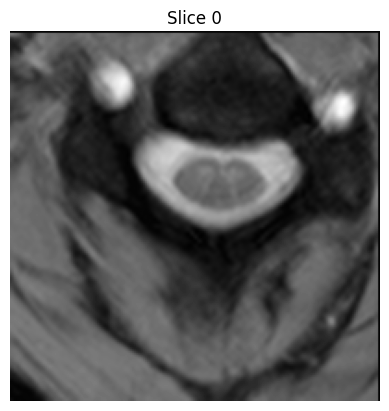

In [ ]:
plt.imshow(resampled_data[:,:,slice_idx].T, cmap='gray', origin='lower')
plt.title(f'Slice {slice_idx}')
plt.axis('off')  
plt.show()

In [1]:
!ls

check_something.ipynb  src			   task_prostate_only_label.py
configs		       task_cardiac_fixmatch.py    task_prostate_supervised.py
log		       task_cardiac_only_label.py  task_spinal_fixmatch.py
main.py		       task_cardiac_supervised.py  task_spinal_only_label.py
make_table.ipynb       task_fundus_fixmatch.py	   task_spinal_supervised.py
memo.txt	       task_fundus_only_label.py   train_semi.sh
mnt		       task_fundus_supervised.py   train_supervised.sh
scripts		       task_prostate_fixmatch.py   wandb


In [2]:
best_path = '/media/morikawa/DataHDD/home/data/segmentation/spinal/semi/domain_generalization/experiment_client_1/checkpoints/fixmatch_20241110_113752/'
import torch

def load_checkpoint(filename, model, optimizer):
    """
    Loads the saved state of the training process.
    """
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    best_loss = checkpoint['best_test_loss']

    return model, optimizer, epoch, best_loss



In [4]:
from src.model.unet import UNet
import yaml
import os
config_path = os.path.join(best_path, 'run_conf.yaml')
cfg = yaml.safe_load(open(config_path))
num_channels = cfg["model"]["num_channels"]
num_classes = cfg["model"]["num_classes"]
model = UNet(num_channels, num_classes) 
optimizer = torch.optim.SGD(model.parameters(), lr=cfg["train"]["optimizer"]['lr'],
            momentum=cfg["train"]["optimizer"]['momentum'], weight_decay=cfg["train"]["optimizer"]['weight_decay'])

In [6]:
best = os.path.join(best_path, 'best_loss')
m, o, e, b = load_checkpoint(best, model, optimizer)
print(b)

{'experiment_client_1_test/cord_dc': 0.8070762157440186, 'experiment_client_1_test/grey_dc': 0.1141192689538002, 'experiment_client_1_test/avg_dc': 0.4605977535247803, 'experiment_client_1_test/jc': 0.373898446559906, 'experiment_client_1_test/hd': 139.7045135498047, 'experiment_client_1_test/asd': 63.61751937866211}
